In [1]:
task_to_metric = {
            "mrpc" : "eval_accuracy",  "cola" : "eval_matthews_correlation", 
            "rte" :'eval_accuracy', "sst2" :'eval_accuracy', "stsb" :'eval_pearson',
            "wnli" :'eval_accuracy', "squad_v2": "f1", "mnli": "eval_accuracy", 
            "qnli": "eval_accuracy", "qqp": "eval_accuracy"
}

base_model_list = [
    "albert-base-v2", 
    "albert-large-v2",
    "bert-base-uncased", 
    "bert-large-uncased", 
    "distilbert-base-uncased",
    "distilroberta-base", 
    "electra-base-discriminator",
    "electra-large-discriminator",
    "roberta-base", 
    "roberta-large",
    "xlm-roberta-base", 
    "xlm-roberta-large"
]


colors = [
    'tab:blue',
    'tab:blue',
    'tab:orange',
    'tab:orange',
    'tab:purple',
    'tab:purple',
    'tab:pink',
    'tab:pink',
    'tab:olive',
    'tab:olive',
    'tab:cyan',
    'tab:cyan'
]

markers_1 = [
    '.',
    'x',
    '.',
    'x',
    '.',
    'x',
    '.',
    'x',
    '.',
    'x',
    '.',
    'x'
]

markers_2 = [
    'o',
    '^',
    'd',
    '+',
    'x',
    'o',
    '^',
    'd',
    '+',
    'x'
]

# Task for title
task_title = {
    "cola":'CoLA', 
    "mrpc":'MRPC',
    "rte" :'RTE', 
    "sst2" :'SST2', 
    "stsb" :'STSB',
    "wnli" :'WNLI', 
    "squad_v2": 'SQuADv2',
    "mnli": 'MNLI', 
    "qnli": 'QNLI', 
    "qqp": 'QQP'
}

In [18]:
import dill
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
import math
from scipy import stats
import sys
import glob
import torch
import torch.nn as nn

sys.path.append('..')

import ptm_recommender.graph_models.graph_util as util
from ptm_recommender.graph_models.gcnn.gin_utils import graph_to_s2vgraphs

torch.set_num_threads(2)
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tasks = list(task_to_metric.keys())

DILL_PATH = '../ptm_model_bench/base_model_dataset/'
MODEL_PATH = '../results/gcnn_ptm_model_bench/'
PERFORMANCE_PATH = '../ptm_model_bench/performance/'
OUTPUT_NAME = 'result'

performance_results_base_path='../ptm_model_bench/performance/'


In [32]:
def transform_to_s2graph(base_model, performance, feature_dim ):
    graph_info = [base_model]
    graph_info_graphs = [x[0] for x in graph_info]
    graph_info_params = [x[1] for x in graph_info]
    graph_info_model_nm = [x[2] for x in graph_info]
    for (G, p) in zip(graph_info_graphs, graph_info_params):
        G.graph['feat_dim'] = feature_dim
        param_keys = p.keys()
        for u in util.node_iter(G):
            label = util.node_dict(G)[u]['label']
            if label in param_keys:
                feature = p[label]
                if feature.shape[0] != feature_dim:
                    assert feature.shape[0] == feature_dim
            else:
                feature = torch.zeros(feature_dim).squeeze()
            util.node_dict(G)[u]['feat'] = feature.float() 
    test_accuracies = [performance[nm][task_to_metric[task]] for nm in graph_info_model_nm if nm in performance.keys()]
    test_graphs = graph_to_s2vgraphs(graph_info_graphs, test_accuracies, graph_info_model_nm)
    return test_graphs

def load_base_model_result(task, performance, prefix = 'base_'):
    model_path = f'{MODEL_PATH}/model_{OUTPUT_NAME}_{task}.pth'
    
    model = torch.load(model_path, map_location=device)
    model.device=device
    
    list_of_models = glob.glob(f"../ptm_model_bench/base_model_dataset/*")
    feature_dim = 128
    result = {'total_result' : []}
    for idx, model_path in enumerate(list_of_models):
        model_type =  model_path.split('/')[-1]
        if model_type.startswith(prefix) is False:
            continue
        with open(model_path, 'rb') as f:
            base_model_dataset=dill.load(f)
        
        for base_model in base_model_dataset:
            if base_model[2] not in performance.keys():
                continue
            test_graphs = transform_to_s2graph(base_model, performance, feature_dim)
            y_pred = model(test_graphs)
        model_nm = base_model_dataset[0][2]
        true_accuracy = performance[model_nm][task_to_metric[task]] if task!='squad_v2' \
                        else performance[model_nm][task_to_metric[task]]/100
        result['total_result'].append({'true_accuracy': true_accuracy,
                             'pred_accuracy': y_pred.view(-1).detach().cpu().numpy()[0],
                             'model_name': base_model_dataset[0][2]})
    return result, test_graphs

def get_perf_and_logme(task, prefix='seen_base_models/base_'):
    model_results_base_path = f'../results/gcnn_ptm_model_bench'  ## 이부분만 제가 쓰는 폴더
    with  open(os.path.join(model_results_base_path,'{}_{}.dill'.format(OUTPUT_NAME ,task)),'rb') as f:
        model_result = dill.load(f)
    with  open(os.path.join(performance_results_base_path, prefix + '{}_performance_score.json'.format(task)), 'r') as f:
        performance = json.load(f)
    try:
        with  open(os.path.join(performance_results_base_path, '{}_logme.json'.format(task)), 'r') as f:
            logme = json.load(f) 
    except:
        logme=None
    return model_result, performance, logme

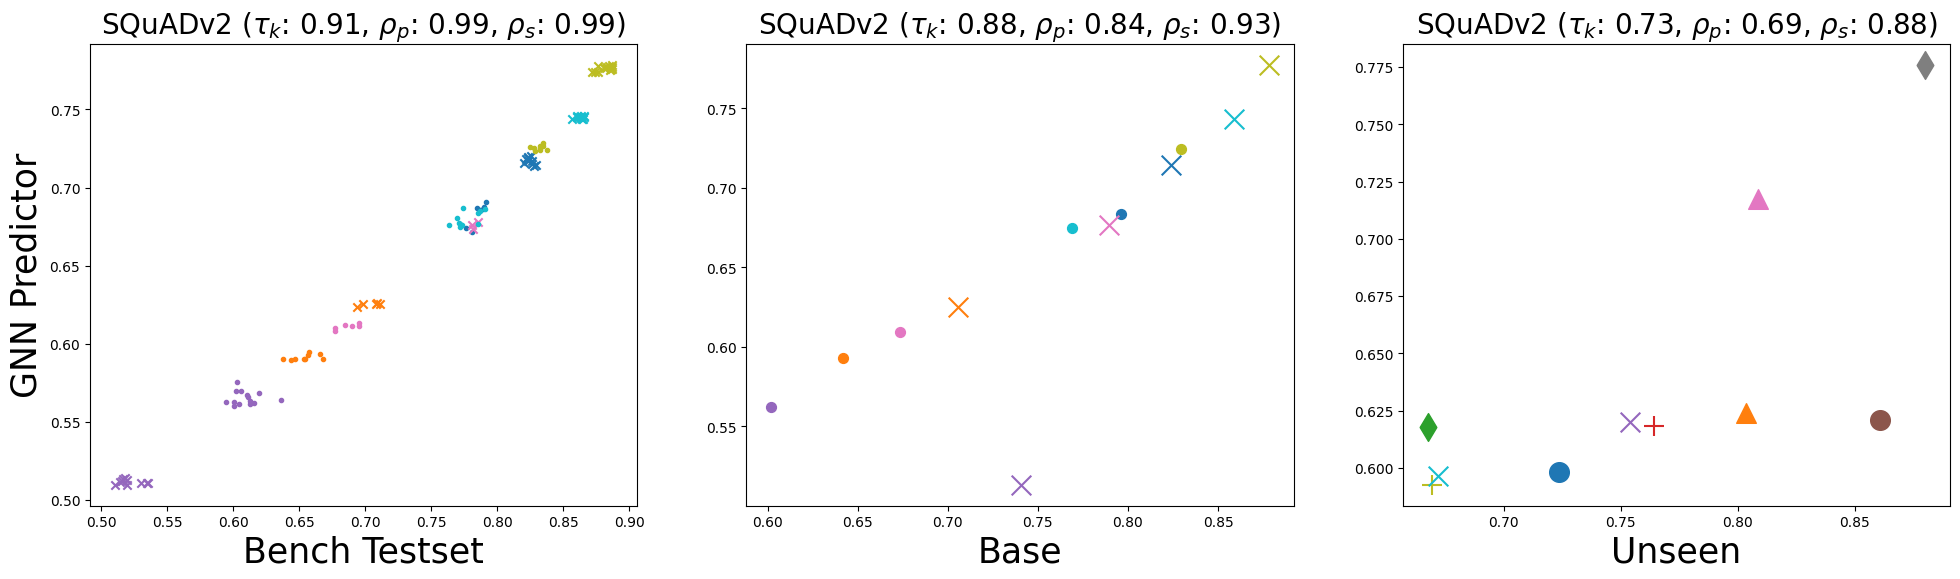

In [33]:

task = "squad_v2"

fig = plt.figure(figsize=(24,6))

num_col = 4
num_row = 1


logmes=[]
perfs=[]
gnn_preds =[]
base_model_list = base_model_list        
model_result, performance, logme = get_perf_and_logme(task)

for idx, base_model in enumerate(base_model_list):
    gnn_pred_list = [ x['pred_accuracy'] for x in model_result['total_result'] if base_model == x['model_name'].split('_')[0] ]
    perf_list = [ x['true_accuracy'] for x in model_result['total_result'] if base_model == x['model_name'].split('_')[0] ]
    model_names = [x['model_name'] for  x in model_result['total_result'] if base_model == x['model_name'].split('_')[0]  ]


    # for drop based on perf
    ind_list = []
    for rdx in range(len(perf_list)):
        ind_list.append(rdx) if perf_list[rdx] > 0.1 else None

    gnn_pred_list = [gnn_pred_list[x] for x in ind_list]
    perf_list = [perf_list[x] for x in ind_list]



    if len(perf_list) > 0:

        perfs += perf_list
        gnn_preds += gnn_pred_list

        # GNN Predictor
        plt.subplot(1, 3, 1)
        plt.scatter(perf_list, gnn_pred_list, marker=markers_1[idx], color=colors[idx], label=base_model)
        plt.ylabel('GNN Predictor', fontsize=25)
        plt.xlabel('Bench Testset', fontsize=25)

        if idx == len(base_model_list)-1:
            tau, tau_p_value = stats.kendalltau(perfs, gnn_preds)
            pearson_cor, pearson_p_value = stats.pearsonr(torch.Tensor(perfs).numpy(), gnn_preds)
            spearman_cor, spearman_p_value = stats.spearmanr(torch.Tensor(perfs).numpy(), gnn_preds)
            plt.title(task_title[task] + r' ($\tau_k$: ${:.2f}$, $\rho_p$: ${:.2f}$, $\rho_s$: ${:.2f}$)'.format(tau, pearson_cor, spearman_cor), fontsize=20)
 
    
with  open( f'{PERFORMANCE_PATH}/seen_base_models/base_{task}_performance_score.json', 'r') as f:
    performance = json.load(f)
    performance = performance[task]
model_result, test_graph = load_base_model_result(task, performance)
perfs = []
gnn_preds = []


for idx, base_model in enumerate(list(performance.keys())):
    gnn_pred_list = [ x['pred_accuracy'] for x in model_result['total_result'] if base_model == x['model_name'] ]
    perf_list = [ x['true_accuracy'] for x in model_result['total_result'] if base_model == x['model_name'] ]

    perfs += perf_list
    gnn_preds += gnn_pred_list

    plt.subplot(1,3,2)
    plt.scatter(perf_list, gnn_pred_list, s=200, marker=markers_1[idx], color=colors[idx], label=base_model)
#     plt.ylabel('GNN Predictor', fontsize=25)
    plt.xlabel('Base', fontsize=25)

    if idx == len(list(performance.keys()))-1:
        tau, tau_p_value = stats.kendalltau(perfs, gnn_preds)
        pearson_cor, pearson_p_value = stats.pearsonr(torch.Tensor(perfs).numpy(), gnn_preds)
        spearman_cor, spearman_p_value = stats.spearmanr(torch.Tensor(perfs).numpy(), gnn_preds)
        plt.title(task_title[task] + r' ($\tau_k$: ${:.2f}$, $\rho_p$: ${:.2f}$, $\rho_s$: ${:.2f}$)'.format(tau, pearson_cor, spearman_cor), fontsize=20)
     
#     plt.legend(loc='center right', bbox_to_anchor=(2, 0.5), borderaxespad=0., fontsize=15)
            
        
        
interested_models =[ 'bert-base-cased',
                    'bert-large-cased',
                    'bert-base-multilingual-uncased',
                    'bert-base-multilingual-cased',
                    'bert-large-uncased-whole-word-masking',
                    'bert-large-cased-whole-word-masking',
                    'roberta-base-openai-detector',
                    'roberta-large-openai-detector',
                    'distilbert-base-cased',
                    'distilbert-base-multilingual-cased'
                 ]

with  open( f'{PERFORMANCE_PATH}/unseen_base_models/unrelated_base_{task}_performance_score.json', 'r') as f:
        performance = json.load(f)
        performance = performance[task]

model_result, test_graph = load_base_model_result(task, performance, prefix='unseen_base_')
perfs = []
gnn_preds = []

for idx, base_model in enumerate(interested_models):

    gnn_pred_list = [ x['pred_accuracy'] for x in model_result['total_result'] if base_model == x['model_name'] ]
    perf_list = [ performance[base_model][task_to_metric[task]]  ]

    if task == 'squad_v2':
        perf_list = [x/100 for x in perf_list]

    perfs += perf_list
    gnn_preds += gnn_pred_list

    plt.subplot(1,3,3)
    plt.scatter(perf_list, gnn_pred_list, s=200, marker=markers_2[idx], label=base_model)
  
#     plt.ylabel('GNN Predictor', fontsize=25)
    plt.xlabel('Unseen', fontsize=25)

    if idx == len(interested_models)-1:
        tau, tau_p_value = stats.kendalltau(perfs, gnn_preds)
        pearson_cor, pearson_p_value = stats.pearsonr(torch.Tensor(perfs).numpy(), gnn_preds)
        spearman_cor, spearman_p_value = stats.spearmanr(torch.Tensor(perfs).numpy(), gnn_preds)
        plt.title(task_title[task] + r' ($\tau_k$: ${:.2f}$, $\rho_p$: ${:.2f}$, $\rho_s$: ${:.2f}$)'.format(tau, pearson_cor, spearman_cor), fontsize=20)

#     plt.legend(loc='center right', bbox_to_anchor=(2, 0.5), borderaxespad=0., fontsize=15)
#     if tdx == len(tasks)-1:
#         ax = plt.legend(ncol=1, loc='lower center', bbox_to_anchor=(-1.3, -0.4), borderaxespad=0., fontsize=13)
        
# plt.annotate('', xy=(-3.6, -0.16), xycoords='axes fraction', xytext=(-2.6, -0.16), arrowprops=dict(arrowstyle="<-", color='black'))
# fig.text(0.38, 0.095, 'True performance', ha='center', fontsize=25)
# plt.show()
plt.savefig('prediction_squadv2_main.png', dpi=200)